## Credit Card Fraud

Data Has been sourced from Kaggle

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
# Starting with useful imports
import csv
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import sklearn.metrics as metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
ls MyDrive/'Colab Notebooks'

'Assignment_1 Linear regression.ipynb'
'Assignment 1 - Logistic regression.ipynb'
'Assignment_1_Logistic regression using cross entropy (One VS Rest).ipynb'
'Assignment 2 XOR with backpropogation.ipynb'
'Assignment 3 - Backprop for Iris Dataset (Python code).ipynb'
'assignmentListStringDict (1).tar'
 assignmentListStringDict.tar
 Boolean_Assignement_RitaThakor.ipynb
 Complex_Assignement_RitaThakor.ipynb
 Conditional_and_loop_assignment_RitaThakor.ipynb
'Copy of List_Assignment.ipynb'
'Copy of Tensorflow_2_Practice.ipynb'
 creditcard.csv
'Credit card fraud.ipynb'
 Dictionary_Assignment_RitaThakor.ipynb
 float_assignment_RitaThakor.ipynb
 Function_Assignment-RitaThakor.ipynb
 int_assignment_RitaThakor.ipynb
 List_Assignment_RitaThakor.ipynb
 Numpy_assignment_RitaThakor.ipynb
'string_assignment_ritathakor (1).ipynb'
 string_assignment_ritathakor.ipynb
 Tensorflow_2_Practice.ipynb
 Untitled0.ipynb
 Untitled1.ipynb
 WordToVec-SkipGram.ipynb


In [ ]:
fname = 'MyDrive/Colab Notebooks/creditcard.csv'
all_features = []
all_targets = []
with open(fname) as f:
  for i, line in enumerate(f):
    if i == 0:
      print('HEADER:', line.strip())
      continue  # Skip header
    fields = line.strip().split(',')
    all_features.append([float(v.replace('"', '')) for v in fields[:-1]])
    all_targets.append([int(fields[-1].replace('"', ''))])
    if i == 1:
      print('EXAMPLE FEATURES:', all_features[-1])
    
features = np.array(all_features, dtype='float32')
targets = np.array(all_targets, dtype='uint8')
print('features.shape:', features.shape)
print('targets.shape:', targets.shape)

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


**Split the samples in train and test**

In [ ]:
num_test_samples = int(len(features) * 0.2)
train_features = features[:-num_test_samples]
train_targets = targets[:-num_test_samples]
test_features = features[-num_test_samples:]
test_targets = targets[-num_test_samples:]
print('Number of training samples:', len(train_features))
print('Number of test samples:', len(test_features))

Number of training samples: 227846
Number of test samples: 56961


**check 0 and 1 distribution with respect to total samples**

In [ ]:
counts = np.bincount(train_targets[:, 0])
print('Number of positive samples in training data: {} ({:.2f}% of total)'.format(counts[1], 100 * float(counts[1]) / len(train_targets)))

Number of positive samples in training data: 417 (0.18% of total)


In [ ]:
counts = np.bincount(test_targets[:, 0])
print('Number of positive samples in testing data: {} ({:.2f}% of total)'.format(counts[1], 100 * float(counts[1]) / len(test_targets)))

Number of positive samples in testing data: 75 (0.13% of total)


**standardise features by subtracting it with mean and diving by std deviation**

In [ ]:
mean = np.mean(train_features, axis=0)
train_features -= mean
test_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
test_features /= std

In [ ]:
train_features.shape

(227846, 30)

**function for ploting confusion matrix, ROC curve, F1Score**

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = metric.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([40,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
def F1Scrore(ytrue, ypred, beta=1.0, threshold=0.5):
  ypred = np.array(ypred >= threshold, dtype=np.float32)

  return fbeta_score(ytrue, ypred, beta)

**Model 1  -classification problem with unbalanced data**

In [ ]:
num_val_samples = 68353
x_val = train_features[-num_val_samples:]
y_val = train_targets[-num_val_samples:]
x_train_val = train_features[:-num_val_samples]
y_train_val = train_targets[:-num_val_samples]


In [ ]:
x_train_val.shape

(159493, 30)

In [ ]:
listMetric = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [ ]:

# Instantiate a simple classification model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dense(8, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=listMetric)

Selecting batch size as larger to have class of 1 also available in it.

In [ ]:
matric_history = model.fit(x_train_val, y_train_val,
          validation_data=(x_val, y_val),
          epochs=20,
          batch_size=2000, verbose=1)

Epoch 1/20
80/80 [==============================] - 1s 8ms/step - loss: 0.9253 - accuracy: 0.5048 - precision: 0.0035 - recall: 0.8770 - val_loss: 0.6516 - val_accuracy: 0.6948 - val_precision: 0.0022 - val_recall: 0.7377
Epoch 2/20
80/80 [==============================] - 0s 5ms/step - loss: 0.4722 - accuracy: 0.9709 - precision: 0.0399 - recall: 0.5225 - val_loss: 0.3449 - val_accuracy: 0.9906 - val_precision: 0.0426 - val_recall: 0.4426
Epoch 3/20
80/80 [==============================] - 0s 4ms/step - loss: 0.2013 - accuracy: 0.9980 - precision: 0.5691 - recall: 0.4860 - val_loss: 0.1868 - val_accuracy: 0.9990 - val_precision: 0.4423 - val_recall: 0.3770
Epoch 4/20
80/80 [==============================] - 0s 5ms/step - loss: 0.0724 - accuracy: 0.9987 - precision: 0.8364 - recall: 0.5169 - val_loss: 0.1150 - val_accuracy: 0.9993 - val_precision: 0.7059 - val_recall: 0.3934
Epoch 5/20
80/80 [==============================] - 0s 4ms/step - loss: 0.0325 - accuracy: 0.9987 - precision: 0

In [ ]:
ret = model.evaluate(test_features, test_targets,batch_size=2000, verbose=1)
print("Loss: {:0.4f}".format(ret[0]))

29/29 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9994 - precision: 0.9388 - recall: 0.6133
Loss: 0.0192


In [ ]:
y_pred_train = model.predict(train_features, batch_size=2000)

In [ ]:
y_pred_test = model.predict(test_features, batch_size=2000)

F1Score for train data 0.7591836734693876


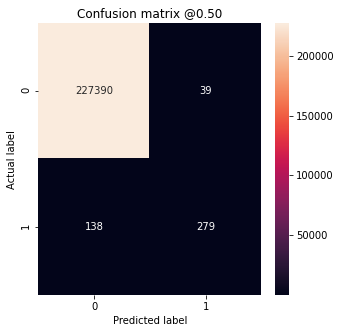

In [ ]:
plot_cm(train_targets, y_pred_train)
print("F1Score for train data",F1Scrore(train_targets, y_pred_train))

F1Score for test data 0.7419354838709676


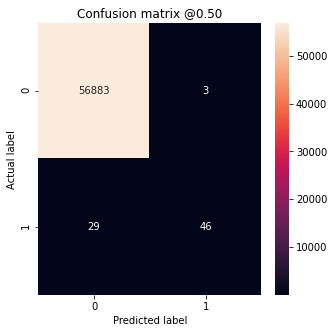

In [ ]:
print("F1Score for test data",F1Scrore(test_targets, y_pred_test))
plot_cm(test_targets, y_pred_test)

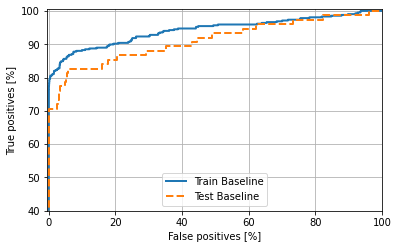

In [ ]:
plot_roc("Train Baseline", train_targets, y_pred_train)
plot_roc("Test Baseline", test_targets, y_pred_test, linestyle='--')
plt.legend(loc='lower center')

**Model -2 Use Smote for unbalanced classes and fit the model again**

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(train_features, train_targets)
class_0_count = np.count_nonzero(y_train_smote == 0)
class_1_count = np.count_nonzero(y_train_smote == 1)
print(len(y_train_smote))
# smote_value_counts = y_train_smote["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (class_0_count * 100 / len(y_train_smote)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


454858
Fraudulent transactions are 50.00% of the test set.


In [ ]:
class_0_count + class_1_count

454858

In [ ]:
num_val_samples = 68353*2 # doubled the sample of test here, as no of samples gets doubled in output of smote
x_smote_val = X_train_smote[-num_val_samples:]
y_smote_val = y_train_smote[-num_val_samples:]
x_smote_train_val = X_train_smote[:-num_val_samples]
y_smote_train_val = y_train_smote[:-num_val_samples]

In [ ]:
x_smote_val.shape

(136706, 30)

In [ ]:
# Instantiate a simple classification model
modelWithSmote = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(8, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [ ]:
modelWithSmote.compile(loss='binary_crossentropy', optimizer='adam', metrics=listMetric)

In [ ]:
matric_history = modelWithSmote.fit(x_smote_train_val, y_smote_train_val,
          validation_data=(x_smote_val, y_smote_val),
          epochs=20,
          batch_size=30, verbose=1)

Epoch 1/20
10606/10606 [==============================] - 41s 4ms/step - loss: 0.0468 - accuracy: 0.9863 - precision: 0.9809 - recall: 0.9620 - val_loss: 0.0326 - val_accuracy: 0.9919 - val_precision: 1.0000 - val_recall: 0.9919
Epoch 2/20
10606/10606 [==============================] - 39s 4ms/step - loss: 0.0123 - accuracy: 0.9968 - precision: 0.9913 - recall: 0.9977 - val_loss: 0.0311 - val_accuracy: 0.9898 - val_precision: 1.0000 - val_recall: 0.9898
Epoch 3/20
10606/10606 [==============================] - 40s 4ms/step - loss: 0.0086 - accuracy: 0.9978 - precision: 0.9940 - recall: 0.9983 - val_loss: 0.0093 - val_accuracy: 0.9986 - val_precision: 1.0000 - val_recall: 0.9986
Epoch 4/20
10606/10606 [==============================] - 39s 4ms/step - loss: 0.0065 - accuracy: 0.9984 - precision: 0.9955 - recall: 0.9989 - val_loss: 0.0066 - val_accuracy: 0.9994 - val_precision: 1.0000 - val_recall: 0.9994
Epoch 5/20
10606/10606 [==============================] - 39s 4ms/step - loss: 0.005

In [ ]:
retModelWithSmote = modelWithSmote.evaluate(test_features, test_targets)
("Loss: {:0.4f}".format(ret[0]))

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0166 - accuracy: 0.9994 - precision: 0.7910 - recall: 0.7067


'Loss: 0.0192'

In [ ]:
y_pred_train_smote = modelWithSmote.predict(train_features)

In [ ]:
y_pred_test_smote = modelWithSmote.predict(test_features)

F1Score for train data 0.8748685594111462


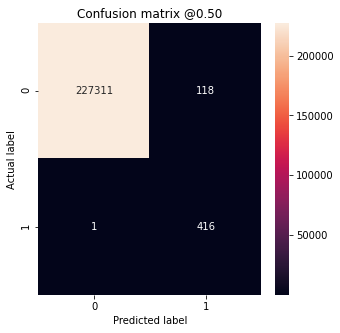

In [ ]:
plot_cm(train_targets, y_pred_train_smote)
print("F1Score for train data",F1Scrore(train_targets, y_pred_train_smote))

F1Score for test data 0.7464788732394366


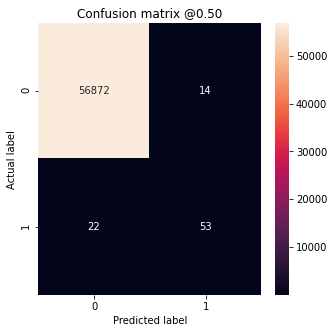

In [ ]:
plot_cm(test_targets, y_pred_test_smote)
print("F1Score for test data",F1Scrore(test_targets, y_pred_test_smote))